# Using 🦙llama-agents🤖 with Milvus

# Milvus
Milvus is an open-source vector database that powers AI applications with vector embeddings and similarity search.

Milvus Lite can be imported into your Python application, providing the core vector search functionality of Milvus. Milvus Lite is included in the Python SDK of Milvus, thus it can be simply deployed with pip install pymilvus. This repo contains the core components of Milvus Lite.

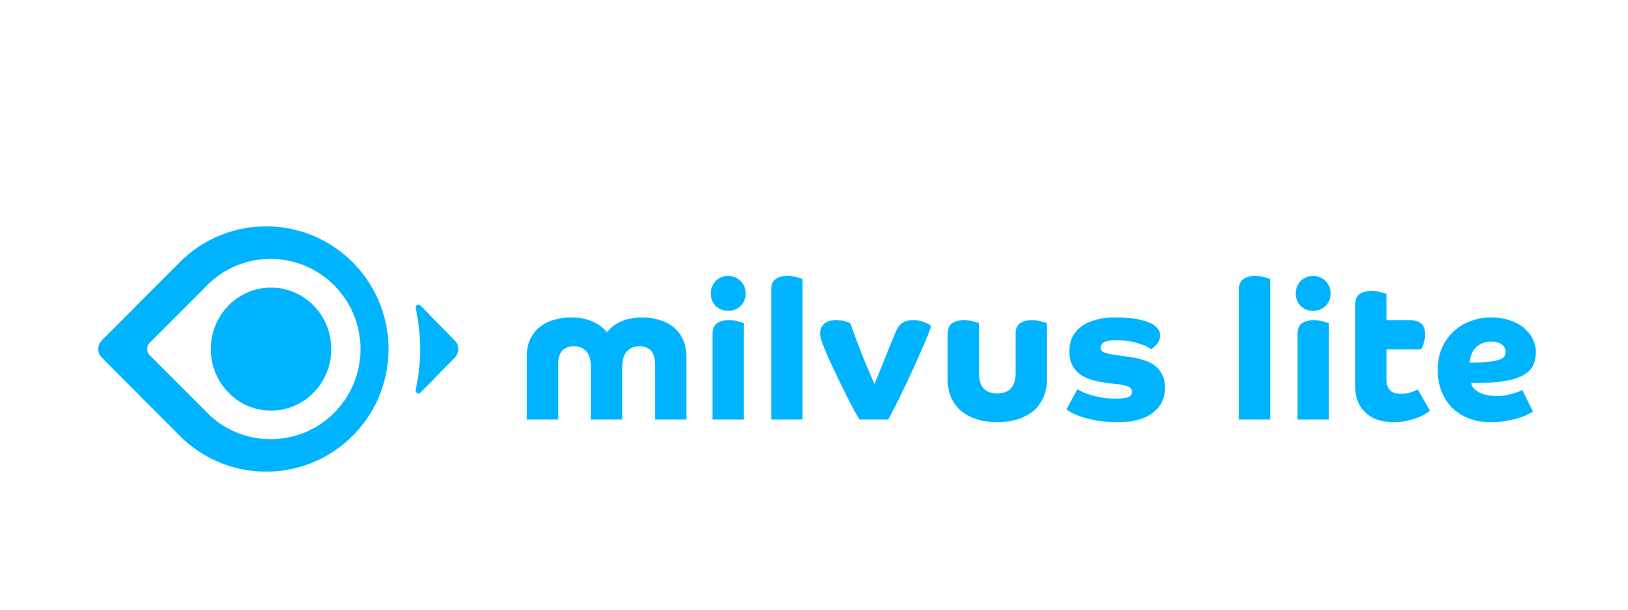

# llama-agents
`llama-agents` makes it possible to run agents as microservices. That makes it possible to scale services up and down.

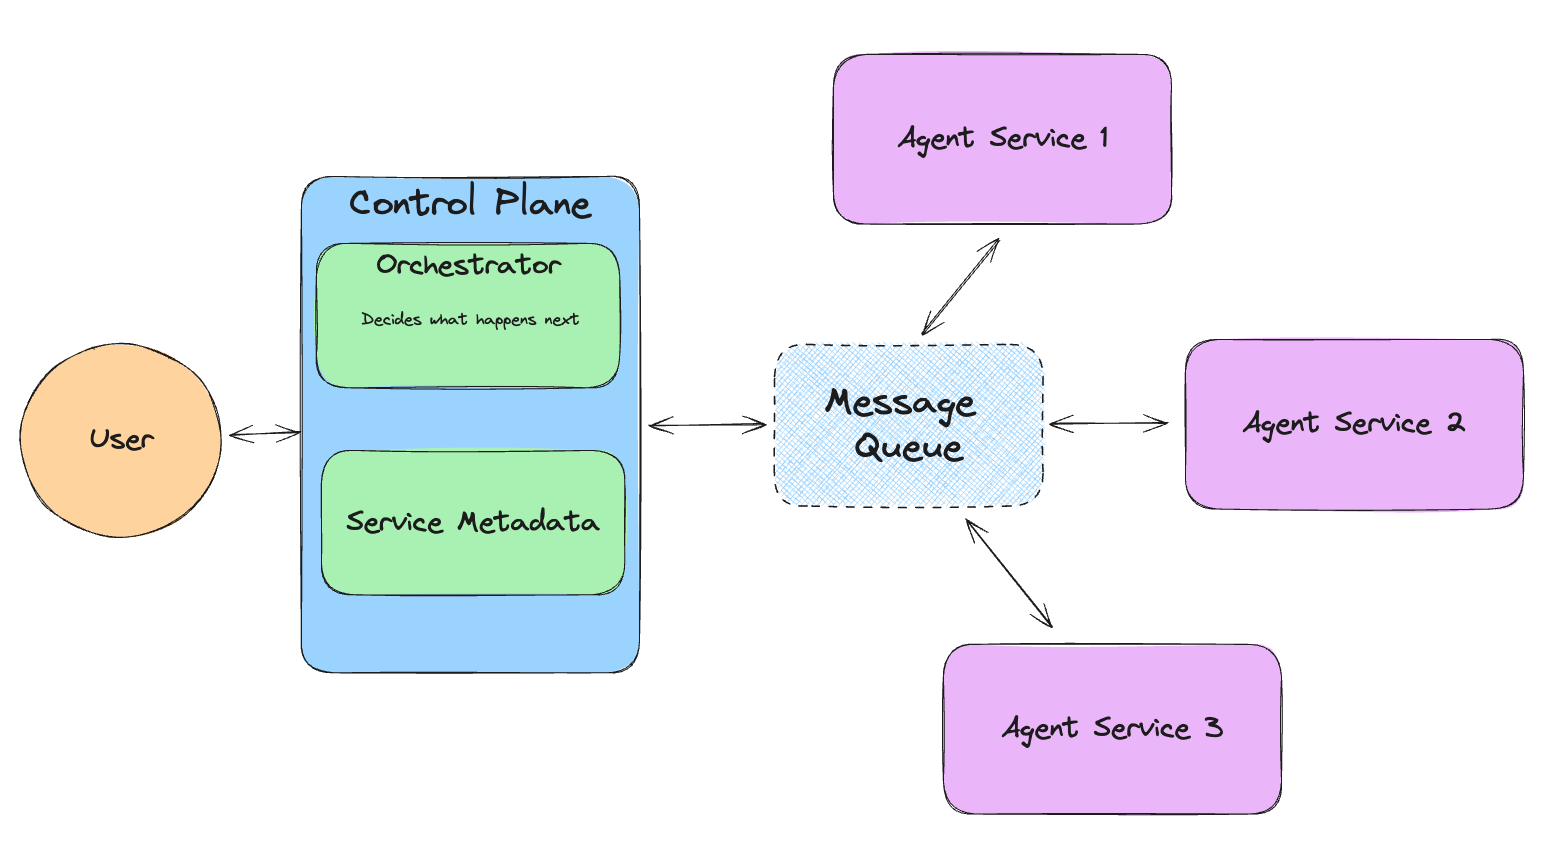

# Install Dependencies

In [ ]:
! pip install llama-agents pymilvus openai python-dotenv

In [ ]:
! pip install llama-index-vector-stores-milvus llama-index-agent-openai llama-index-readers-file llama-index-embeddings-huggingface

In [55]:
# This is needed when running the code in a Notebook
import nest_asyncio
nest_asyncio.apply()

In [2]:
from dotenv import load_dotenv
import os 

load_dotenv()

## Download data

In [3]:
!mkdir -p 'data/10k/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/uber_2021.pdf' -O 'data/10k/uber_2021.pdf'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/lyft_2021.pdf' -O 'data/10k/lyft_2021.pdf'


--2024-07-30 17:15:08--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/uber_2021.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1880483 (1.8M) [application/octet-stream]
Saving to: ‘data/10k/uber_2021.pdf’

data/10k/uber_2021. 100%[===================>]   1.79M  --.-KB/s    in 0.1s    

2024-07-30 17:15:08 (13.3 MB/s) - ‘data/10k/uber_2021.pdf’ saved [1880483/1880483]

--2024-07-30 17:15:08--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/10k/lyft_2021.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|26

In [64]:
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Define the default Embedding model used in this Notebook.
# bge-small-en-v1.5 is a small Embedding model, it's perfect to use locally
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

In [5]:
from llama_index.vector_stores.milvus import MilvusVectorStore
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index.core.tools import QueryEngineTool, ToolMetadata

# Create a single Milvus vector store
vector_store = MilvusVectorStore(
    uri="./milvus_demo.db",
    dim=384,
    overwrite=True,
    collection_name="lyft_docs"  # Default collection name
)

# Create a storage context with the Milvus vector store
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Function to load or build the index for a given collection
def load_or_build_index(collection_name: str, input_files: list[str], persist_dir: str):
    try:
        # Try to load the index from storage
        storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
        index = load_index_from_storage(storage_context)
        index_loaded = True
    except:
        index_loaded = False

    if not index_loaded:
        # Load data
        docs = SimpleDirectoryReader(input_files=input_files).load_data()

        # Build index
        index = VectorStoreIndex.from_documents(docs, vector_store=vector_store, collection_name=collection_name)

        # Persist index
        index.storage_context.persist(persist_dir=persist_dir)

    return index

# Load or build the index for Lyft documents
lyft_index = load_or_build_index(
    collection_name="lyft_docs",
    input_files=["./data/10k/lyft_2021.pdf"],
    persist_dir="./storage/lyft"
)

# Load or build the index for Uber documents
uber_index = load_or_build_index(
    collection_name="uber_docs",
    input_files=["./data/10k/uber_2021.pdf"],
    persist_dir="./storage/uber"
)

# Now you have two indices, lyft_index and uber_index, each using a different collection


In [6]:
# Define the query engine
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3)
uber_engine = uber_index.as_query_engine(similarity_top_k=3)

In [46]:
# Define the different tools that can be used by our Agent. 
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_engine,
        metadata=ToolMetadata(
            name="lyft_10k",
            description=(
                "Provides information about Lyft financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
    QueryEngineTool(
        query_engine=uber_engine,
        metadata=ToolMetadata(
            name="uber_10k",
            description=(
                "Provides information about Uber financials for year 2021. "
                "Use a detailed plain text question as input to the tool."
            ),
        ),
    ),
]

## llama-agents

We define the different tools available to `llama-agents`, this is how our Agent will know which one it has access to and when to use it. 

In [56]:
from llama_agents import (
    AgentService,
    ToolService,
    LocalLauncher,
    MetaServiceTool,
    ControlPlaneServer,
    SimpleMessageQueue,
    AgentOrchestrator,
)

from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.llms.openai import OpenAI

# create our multi-agent framework components
message_queue = SimpleMessageQueue()
control_plane = ControlPlaneServer(
    message_queue=message_queue,
    orchestrator=AgentOrchestrator(llm=OpenAI(model="gpt-4o")),
)

# define Tool Service
tool_service = ToolService(
    message_queue=message_queue,
    tools=query_engine_tools,
    running=True,
    step_interval=0.5,
)

# define meta-tools here
meta_tools = [
    await MetaServiceTool.from_tool_service(
        t.metadata.name,
        message_queue=message_queue,
        tool_service=tool_service,
    )
    for t in query_engine_tools
]

# define Agent and agent service
worker1 = FunctionCallingAgentWorker.from_tools(
    meta_tools,
    llm=OpenAI(),
)

agent1 = worker1.as_agent()
agent_server_1 = AgentService(
    agent=agent1,
    message_queue=message_queue,
    description="Used to answer questions over Uber and Lyft 10K documents",
    service_name="uber_lyft_10k_analyst_agent",
)

In [57]:
import logging

# change logging level to enable or disable more verbose logging
logging.getLogger("llama_agents").setLevel(logging.INFO)

In [58]:
## Define Launcher
launcher = LocalLauncher(
    [agent_server_1, tool_service],
    control_plane,
    message_queue,
)

In [59]:
query_str = "What are the risk factors for Uber?"
result = launcher.launch_single(query_str)

INFO:llama_agents.message_queues.simple - Consumer AgentService-81798eeb-4c10-44ca-ac78-5065aaeec70a: uber_lyft_10k_analyst_agent has been registered.
INFO:llama_agents.message_queues.simple - Consumer ToolService-a2f8e22e-5cfb-4d78-8f2a-bbbcdada7865: default_tool_service has been registered.
INFO:llama_agents.message_queues.simple - Consumer 2fcfe825-9b85-436b-9feb-c52c08304af7: human has been registered.
INFO:llama_agents.message_queues.simple - Consumer ControlPlaneServer-698f6253-3289-4f80-b334-74c70e02b45a: control_plane has been registered.
INFO:llama_agents.services.agent - uber_lyft_10k_analyst_agent launch_local
INFO:llama_agents.message_queues.base - Publishing message to 'control_plane' with action 'ActionTypes.NEW_TASK'
INFO:llama_agents.message_queues.simple - Launching message queue locally
INFO:llama_agents.services.agent - Processing initiated.
INFO:llama_agents.services.tool - Processing initiated.
INFO:llama_agents.message_queues.base - Publishing message to 'uber_lyf

In [51]:
print(result)


Here are some of the risk factors for Uber as outlined in their 10-K report for the year 2021:

1. The adverse effects of the COVID-19 pandemic and related mitigation actions.
2. Adverse impact if Drivers were classified as employees instead of independent contractors.
3. Intense competition in the mobility, delivery, and logistics industries.
4. The need to lower fares or service fees to remain competitive.
5. Historical losses and the uncertainty of achieving profitability.
6. Risks associated with attracting and maintaining a critical mass of Drivers, consumers, merchants, shippers, and carriers.
7. The importance of maintaining and enhancing brand reputation.
8. Challenges related to workplace culture and operational compliance.
9. Risks associated with optimizing organizational structure and managing growth effectively.


In [52]:
query_str = "What are the risk factors for Lyft?"
result = launcher.launch_single(query_str)
print(result)

INFO:llama_agents.message_queues.simple - Consumer AgentService-64c10d08-d676-435e-9377-259ae2a1d84d: uber_lyft_10k_analyst_agent has been registered.
INFO:llama_agents.message_queues.simple - Consumer ToolService-9fdc173b-a0ad-41da-bb0f-97c2fb5f0560: default_tool_service has been registered.
INFO:llama_agents.message_queues.simple - Consumer 97e12bf1-0262-4c32-89c8-d9d9be7e287e: human has been registered.
INFO:llama_agents.message_queues.simple - Consumer ControlPlaneServer-1b6c13f4-9ddb-4267-9f6c-0506a769234c: control_plane has been registered.
INFO:llama_agents.services.agent - uber_lyft_10k_analyst_agent launch_local
INFO:llama_agents.message_queues.base - Publishing message to 'control_plane' with action 'ActionTypes.NEW_TASK'
INFO:llama_agents.message_queues.simple - Launching message queue locally
INFO:llama_agents.services.agent - Processing initiated.
INFO:llama_agents.services.tool - Processing initiated.
INFO:llama_agents.message_queues.base - Publishing message to 'uber_lyf

Here are some of the risk factors for Lyft as outlined in their 10-K report for the year 2021:

1. Impact of the COVID-19 pandemic and responsive measures.
2. General economic factors such as natural disasters, economic downturns, public health crises, or political crises.
3. Operational factors including limited operating history, financial performance, competition, unpredictability of results, growth uncertainties, attracting and retaining drivers and riders, insurance coverage, autonomous vehicle technology, reputation and brand, security and privacy breaches, reliance on third parties, managing growth, and development of new offerings.
4. Challenges in forecasting revenue, managing expenses, complying with laws and regulations, capital expenditures, macroeconomic changes, maintaining brand value, expanding geographically, hiring and retaining talent, developing new platform features, and managing business operations.
5. Uncertainty in achieving or maintaining profitability, especia

# Conclusion

In this notebook, you have seen how you can use llama-agents to perform different actions by calling appropriate tools. 
We saw that the Agent could pick the collection containing the data requested by the user. 

It could also be possible to add a other functions, such as Web Search etc. 

# ⭐️ Github
We hope you liked this tutorial showcasing how to use Function Calling using Ollama, Llama 3.1 and Milvus.
If you liked it and our project, please give us a star on [Github](https://github.com/milvus-io/milvus)! ⭐

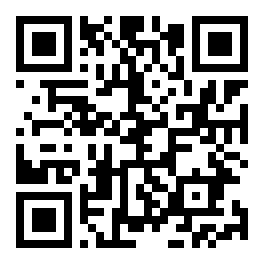


# 🤝 Add me on Linkedin!
If you have some questions related to Milvus, GenAI, etc, I am Stephen Batifol, you can add me on [LinkedIn](https://www.linkedin.com/in/stephen-batifol/) and I'll gladly help you. 

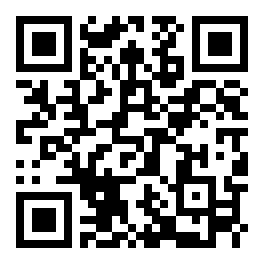